**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 3** - Principal component analysis

**Duration: 3 hours**

**Introduction:**

Hyperspectral images are scientific images of the Earth, acquired by satellites or aicrafts; rather than having three R/G/B color channels, these images have a lot more “color” components obtained through a fine sampling of the wavelength (hence the name “hyper”-spectral). The 
resulting 3-dimensional dataset has one image (spectral band or “color”) for every sampled wavelength, which represents the measured radiance from each pixel at that specific wavelength. Hyperspectral images are very useful for image analysis. For every pixel at a given spatial position, it is possible to extract a so-called spectral vector, i.e. the 1-dimensional vector of values assumed by that pixel at all wavelengths. Assuming that each pixel is composed of just one substance, the spectral vector represents the radiance of that substance at all the wavelengths that have been 
sampled. Spectral vectors, therefore, can be used to infer which substance is contained in a given pixel – a typical classification problem that has a lot of practical applications in agriculture, analysis of land use / land cover, and other applications related to the study of the environment.


In this lab you will use a real hyperspectral image that has been acquired by the AVIRIS instrument, an airborne hyperspectral imager operated by the NASA. The image represents a scene of Indian Pines (Indiana, USA). It has a size of 145x145 pixels and 220 spectral bands. Along with the image, a ground truth is available, in terms of labels specifying which class (out of 16) each pixel belongs to. The classes are reported below; for more information, please see 
http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Indian_Pines

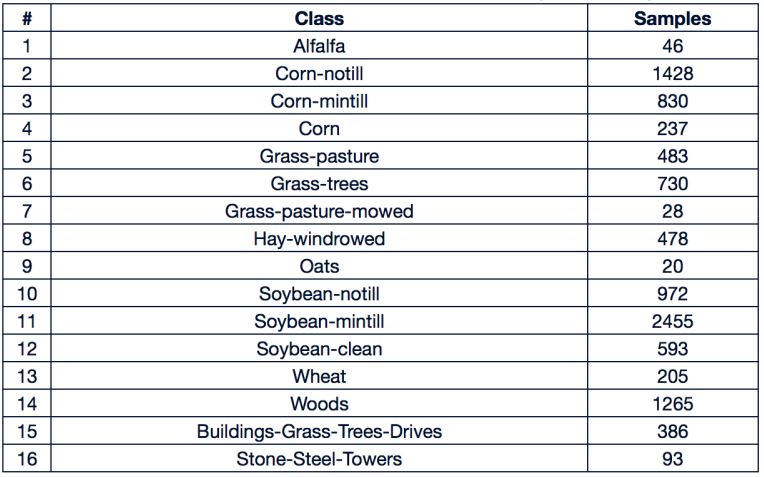

The purpose of this computer lab is twofold:

*   To apply PCA to the spectral vectors in order to reduce their dimensionality.
*   To perform classification on the reduced data (optional)

**Exercise 1 – PCA**


In this exercise, you will employ the Indian Pines dataset. You will not do this for the entire dataset, but only for the spectral vectors belonging to **two classes** (as in the optional exercise you will perform 2-class classification on the PCA coefficients). 

**Reminder:** the input to the PCA must always have zero mean: besides the sample covariance, you will have to compute the **mean value μ** over the training set and subtract it from each test vector before applying PCA.

**Task:** You have to reduce the dimensionality of the spectral vectors of the two classes you have chosen using PCA. In particular, you should perform the following:


*   Extract spectral vectors of two classes, as described above (see sample code below).
*   Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)
*   Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.
  * Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them by yourself.
*   Choose a number of dimensions K<=220.
*   Construct the eigenvector matrix W for K components (i.e., select the last K columns)
*   Using W, compute the PCA coefficients for each spectral vector in the data set
*   Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)
*   Plot the average MSE over the test set as a function of K.
*   Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA

In [3]:
import numpy as np
import h5py
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

# load the matrix of the image, a matrix 145x145x220, where 145x145 are the pixels and 220 are the channels
mat = scipy.io.loadmat('Indian_pines.mat')
indian_pines = np.array(mat['indian_pines'])

# load the matrix of the ground truth, a matrix 145x145, where each pixel has a label
mat = scipy.io.loadmat('Indian_pines_gt.mat')
indian_pines_gt = np.array(mat['indian_pines_gt'])

**Extract spectral vectors of two classes, as described above (see sample code below).**

In [4]:
# we don't perform PCA on the global dataset, but only on the pixels of two selected classes
class1_value = 8    # select the classes to be used
class2_value = 12

# there are 17 classes in the dataset, from 0 to 16. The class 0 is ignored because is the background
class1=np.zeros((2500,220)) # create matrix to store the data of the class, 2500 is the maximum number of pixels in the class
class2=np.zeros((2500,220))
class1_gt=np.zeros(2500) # create matrix to store the labels of the class
class2_gt=np.zeros(2500)
n1=0    # counter for the number of pixels in the class
n2=0

for i in range(145):    # loop through the pixels of the image
    for j in range(145):
        if indian_pines_gt[i,j] == class1_value:    # if the pixel belongs to the class1
            class1[n1,:] = indian_pines[i,j,:]/1.   # store the pixel data in the matrix
            class1_gt[n1] = 0
            n1=n1+1   # increase the number of pixels in the class
        if indian_pines_gt[i,j] == class2_value:    # if the pixel belongs to the class2
            class2[n2,:] = indian_pines[i,j,:]/1.   # store the pixel data in the matrix
            class2_gt[n2] = 1
            n2=n2+1  # increase the number of pixels in the class
            
class1=class1[:n1,:]    # remove the extra zeros
class2=class2[:n2,:]
class1_gt=class1_gt[:n1]
class2_gt=class2_gt[:n2]

**Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)**

In [5]:
# in order to perform PCA we need that the dataset has zero mean
combined = np.vstack((class1, class2))  # build a matrix with the data of the two classes
mean = np.mean(combined, axis=0)    # returns the mean vector of the data (mean for each band)
standard_deviation = np.std(combined, axis=0)  # returns the standard deviation of the data (std for each band)
centered = (combined - mean)/standard_deviation  # for each pixel, subtract the mean of the data for that band
# evaluate the covariance matrix on the centered dataset
cov_matrix = np.cov(centered.T) # covariance matrix - note that it doesn't change with the normalization

**Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.**

In [6]:
from numpy import linalg as LA
# then to perform PCA we have to obtain the matrix of eigenvectors and the vector of eigenvalues, so we can extract the couple of features that explain the most variance
# to perform the eigendecomposition of the covariance matrix, we can use the function eig() from the numpy library

#w, v = LA.eig()
# w[0] corresponds to the first eigenvector, v[:,0]
v,w = LA.eig(cov_matrix) # v - eigenvalues as vector, w - eigenvectors contained in columns of a matrix

#Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them first.
# each eigenvalue is associated to a eigenvector, and the value of the eigenvalue is the amount of variance explained by the eigenvector
# so if we sort in descending order the eigenvalues, we can extract the eigenvector in order of importance
idx = np.argsort(v)[::-1]   # sort eigenvalues in descending order and remember the indexes
v = v[idx]  # sort eigenvalues
w = w[:, idx]   # sort eigenvectors

**Choose a number of dimensions K<=220.Construct the eigenvector  matrix W for K components (i.e., select the last K columns)**

In [7]:
L = 50  # number of eigenvectors to keep - number of latent variables that we want to extract
# W contains the L eigenvectors corresponding to the largest L eigenvalues, which capture the most variance in the data
W = w[:, :L]   # select the first K eigenvectors

**Using W, compute the PCA coefficients for each spectral vector in the data set. Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)**

In [8]:
#Note: remember to remove the mean from the vectors of the dataset
errors = 0  # store the errors for each L

# X_pca rappresents the new dataset with reduced dimensionality, the dimension is NxL, where N is the number of pixels in the classes and L is the number of eigenvectors selected
# reduced dataset
X_pca = np.dot(centered, W)  # X_pca = centered * W
# we use the reduced dataset to reconstruct the original dataset
X_approx = np.dot(X_pca, W.T)  # X_approx = X_pca * W'
# we evaluate the mean squared error between the original dataset and the reconstructed dataset to see how much information we lost in the reduced dataset
errors = np.mean((centered - X_approx)**2)   # calculate the mean squared error
print(f'When L = {L}, the mean squared error is {errors}')

When L = 50, the mean squared error is 0.018335237291201976


**Plot the average MSE over the test set as a function of K.**

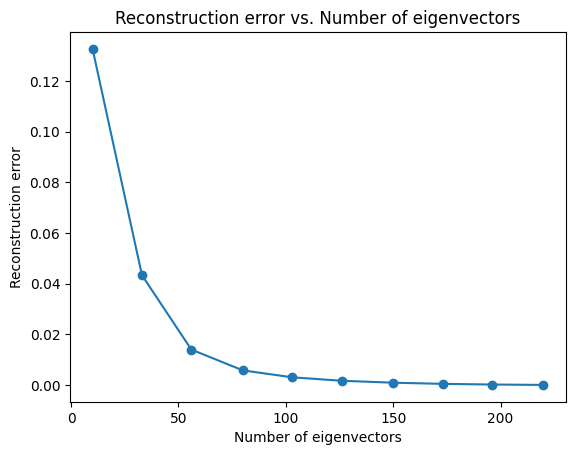

In [9]:
# we want to choose the best value of L, so we try with many possible values and plot the reconstruction error
L = np.linspace(10, 220, 10, dtype=int)  # number of eigenvectors to keep
errors = np.zeros(10)  # store the errors for each K

# when L tend to 0 we are reducing the dataset to a single point, so the error should increase
# when L tend to D (dimension of the original dataset) we are reducing the approximation of the dataset, so the error should decrease
for i, l in enumerate(L):   # perform PCA with different number of eigenvectors extracted
    W = w[:, :l]  # select the first l eigenvectors
    X_pca = np.dot(centered, W)  # X_pca = centered * W
    X_approx = np.dot(X_pca, W.T)  # X_approx = X_pca * W'
    errors[i] = np.mean((centered - X_approx)**2)   # calculate the mean squared error

plt.plot(L, errors)
plt.scatter(L, errors)
plt.xlabel('Number of eigenvectors')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error vs. Number of eigenvectors')
plt.show()

**Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA**

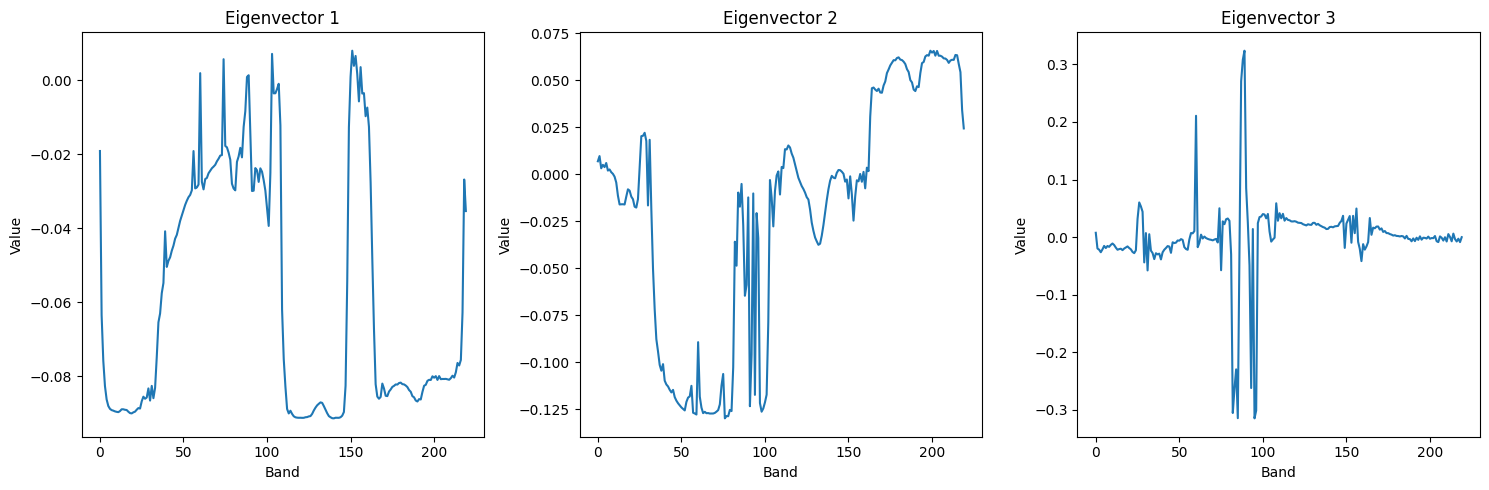

In [10]:
# plot the first 3 eigenvectors
# plotting eigenvectors can give us an idea of the structure of the data
# each eigenvector corresponds to one principal component, this is a new axis in the transformed data that rappresents the direction of maximum variance in the original data.
# each value in the eigenvector represents the weight of the corresponding band in the new axis
# high values indicate that the band strongly influences the corresponding principal component,
# while low values indicate that the band has little influence on the principal component
# positive and negative values indicate the direction of the influence
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):  
    axs[i].plot(W[:, i])    # plot the i-th eigenvector
    axs[i].set_title(f'Eigenvector {i+1}')
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()


**Student's comments to Exercise 1**

**PCA description:**

PCA (Principal Component Analysis) is an algorithm used to reduce the dimensionality of a dataset and minimize the information lost by doing this process. We start from an original dataset composed by N samples, each with dimensionality (number of features) D, and we want to obtain a new dataset composed by N samples but each of L dimensions, whith L < D. The samples of the reduced dataset are called laten variables. These are new variables with new values evaluated by the model starting from the original variables. PCA is the algorithm that has the aim of doing so.

**How PCA works:**

Firstly, in order to help PCA to perform optimaly we must standardize our original data. For doing so we evaluate: $x_{i,j} = \frac{x_{i,j}-\overline{x_{j}}}{\sigma_j}$, where $i$ is the index of the sample and $j$ is the feature index. We do this to remove bias on our dataset, so each feature (column of our dataset) has 0 mean and standard deviation euqal to 1. 
Now, on this standardized dataset we can perform PCA. The formula applied by this algorithm is: $Z = W^T X$, where $Z$ is the dataset made of latent variables with NxL shape, $X$ is the original dataset with NxD shape, W is a matrix of weights that we must evaluate to do this conversion, the shape of this is LxD, so when we transpose it becomes DxL.

**How to find W matrix:**

As W matrix we use the matrix of eigenvectors sorted in descending order of the associated eigenvalues. Note that the eigenvectors matrix is a DxD, where each column correspond to a eigenvector associated to a eigenvalue, we sort the eigenvalues in descending order cause these values indicates the quantity of variance of the associated eigenvector. So, in order to reduce the dimension of the dataset we must extract the first L eigenvectors from this matrix, so we obrain a matrix that contains only the most relevant L eigenvectors.
To find the eigenvectors matrix and the eigenvalues we must perform the eigendecomposition on the covariance matrix. The covariance matrix is evaluated on the standardized dataset and then the eigendecomposition is made by exploiting a python function (LA.eig(matrix)).

**How to choose L:**

L is a parameter to our choice but we don't know which value could be the best for our dataset. We know that PCA puts togheter features that are correlated between them, but if we force it to reduce too much the dimensionality of the dataset, it will put togheter features that are not correlated and so we certainly loose information. To evaluate the best value of L we must measure the quantity on information lost. For doing so we evaluate the MSE (Mean Square Error) between the original dataset and the dataset evaluated by applying the inverse formula on the reduced dataset. So we perform $\hat X = ZW$ and we obtain the predicted original dataset from the reduced one. Then we evaluate $MSE = mean((X - \hat X)^2)$, this formula correspond to the evaluation of the mean between all the square errors evaluated on the rows of those matrices.
So now we know how to evaluate the quantity of information lost in the process of dimension reduction, we can apply PCA with many different vaues of L and see how the error changes. Note that L could only be contained in a domain of [1, D], and we expect that when L tend to 1 the error is maximum, cause we are trying to reduce too much the dimensionality, and when L tend to D the error is minimum, cause we are not reducing the dimensionality. 
When we plot how the error changes through the values of L, we expect to see a decreasing trend as discussed. Then we can decide a value of L that gives us a low error and decrease enough the dimensionality of the dataset.

PCA is an algorithm used to reduce the dimensionality of a dataset while it tries to not loose informations. We can separate its work in steps:
 - Identify key patterns: in order to simplify the calculation it needs a normalized dataset, so at each feature the mean value is removed. Then it calculates the covariance       matrix, that captures how features vary with respect to each other. From this matrix are extracted eigenvalues and eigenvectors (cov * eigenvector_i = eigenvalue_i * eigenvector_i). Eigenvectors rapresent the directions of maximum variance in the data, the eigenvalues rapresent the amout of variance along these directions.
 - Transform the data: it transforms the data into a new dataset with lower dimensions, by removing some irrelevant features. The new dataset (Z) is obtained by multiplying the centered dataset with the eigenvectors, ordered in decreasing order of the associated eigenvalues. (Z = X_cen * V). The new features obtained in Z are uncorrelated and ordered by how much variance they caught, so how much they affect the sapmle. In order to obtain a dataset Z with less features, we use only the K more affective eigenvectors, we do this by selecting the K higher eigenvalues. K is an hyprparameter, so we need to find and choose the best value for our model. 
 - Then we could try to invert the equation Z = X_cen * V and obtain X_cen = Z * V^T. At the results of this we add the mean vector, the same that we removed before for normalization of the dataset. This will give to us the predictions made by the model by using the reduce dataset obtained with PCA. Because we know the right dataset, we could evaluate the error by the MSE. This is usefull in order to find the best value for K, that we visualize in the plot. We see that the error decreases with the increasing of K, this is expected cause an high value of K means that we are selecting more feature from the original set, so we are reducing the approximation.
The last plots compare the first three eigenvectors, so the three eigenvectors that correspond to the higher eigenvalues. So these are the components that affect more the sample, and we see it from the values plotted. The other eigenvectors will have a decreasing impact.

**Exercise 2 – Classification using dimensionality reduction and whitening (optional)**

In this exercise you will apply a simple 2-class linear discriminant analysis (LDA) classifier to the data belonging to the two classes, before and after **whitening** (i.e. applying PCA plus rescaling 
each coefficient to unit variance: $y = \Lambda^{-\frac{1}{2}}W^{T}x$. Note that matrix $\Lambda$ is obtained as one of the outputs of *eig.m*). This classifier makes the Naïve Bayes Classifier assumption that the features are statistically independent, thus the shared covariance matrix is taken as $\Sigma = I$. We also assume that class 0 and class 1 are equiprobable. Thus, letting $\mu_{0}$ and $\mu_{1}$ be the mean of vectors in class 0 and 1, we define $x_{0} = 0.5(\mu_{0} + \mu_{1})$ and $w = \mu_{1}-\mu_{0}$. A test vector $x$ is classified into class 1 or 0 depending on whether $sign(w^{T}(x − x_{0}))$ is equal to +1 or -1.

When the classifier is applied to the PCA coefficients, you simply replace $\mu_{0}$ and $\mu_{1}$ with their reduced versions (subtracting $\mu$ and applying the same PCA matrix computed over the training set), and recalculate $x_{0}$ and $w$ accordingly.

**Task:** Divide the Indian Pines dataset into training and test sets (e.g. 75% of the data of each class to be used as training data, and 25% as test data). Train this classifier on the training data, and 
apply it to the test data. In particular, you should perform the following:
*   Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.
*   Apply the classifier to the original data (without PCA) and compute its accuracy
*   Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy
*   Apply the classifier to the original data where only the first K features have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)
*   Try to classify the data using a Support Vector Machine and compare the results





**Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.**

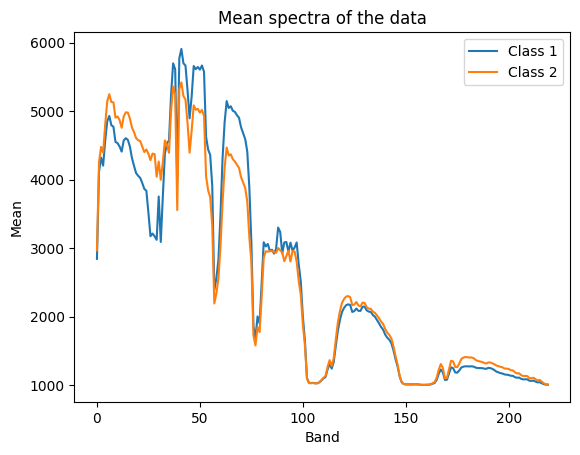

In [32]:
mean_class1 = np.mean(class1, axis=0)  # mean of the training data for class1
mean_class2 = np.mean(class2, axis=0)  # mean of the training data for class2
plt.plot(mean_class1, label='Class 1')
plt.plot(mean_class2, label='Class 2')
plt.xlabel('Band')
plt.ylabel('Mean')  
plt.title('Mean spectra of the data')
plt.legend()
plt.show()

**Apply the classifier to the original data (without PCA) and compute 
its accuracy**

In [34]:
#For this section you can use the code you developed for the previous Lab or the sklearn function LinearDiscriminantAnalysis
# # training set is composed by the 75% of the data of class1 and 75% of the data of class2
# X_train = np.vstack((class1[:int(0.75*class1.shape[0]), :], class2[:int(0.75*class2.shape[0]), :]))  # training data
# # the remaining 25% for each class is used for testing
# X_test = np.vstack((class1[int(0.75*class1.shape[0]):, :], class2[int(0.75*class2.shape[0]):, :]))  # testing data
# # the labels are 0 for class1 and 1 for class2, i have to count how many pixels are in each class to build the labels
# y_train = np.concatenate((np.zeros(int(0.75*class1.shape[0])), np.ones(int(0.75*class2.shape[0]))))  # training labels
# # the remaining labels are used for testing
# y_test = np.concatenate((np.zeros(class1.shape[0]-int(0.75*class1.shape[0])), np.ones(class2.shape[0]-int(0.75*class2.shape[0]))))  # testing labels

# # LDA classifier
# # evaluate the mean of the training data for each class
# mu_0 = np.mean(X_train[y_train == 0], axis=0)  # mean of the training data for class 0
# mu_1 = np.mean(X_train[y_train == 1], axis=0)  # mean of the training data for class 1
# x_0 = 0.5 * (mu_0 + mu_1)  # calculate the threshold
# weights = mu_1 - mu_0    # calculate the weights

# y_pred = np.sign(np.dot((X_test - x_0), weights))  # predict the class of the testing data (-1 is class 0, 1 is class 1)
# y_pred = ((y_pred + 1) / 2).astype(int)  # convert the prediction to 0 and 1

# accuracy = np.mean(y_pred == y_test)  # calculate the accuracy
# print(f'N = {X_train.shape[0]}, D = {X_train.shape[1]}, Accuracy: {accuracy}')

from sklearn.model_selection import train_test_split

# we split the dataset in training and testing data
X_train1, X_test1, y_train1, y_test1 = train_test_split(class1, class1_gt, test_size=0.25, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(class2, class2_gt, test_size=0.25, random_state=42)

# we combine the data of the two classes
X_train = np.vstack((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))
X_test = np.vstack((X_test1, X_test2))
y_test = np.concatenate((y_test1, y_test2))

# apply LDA
mu_0 = np.mean(X_train1, axis=0)  # mean of the training data for class 0
mu_1 = np.mean(X_train2, axis=0)  # mean of the training data for class 1

w = mu_1 - mu_0   # calculate the weights
x_0 = 0.5 * (mu_0 + mu_1)  # calculate the threshold
y_pred = np.sign(np.dot(X_test - x_0, w))  # predict the class of the testing data (-1 is class 0, 1 is class 1)
y_pred = ((y_pred + 1) / 2).astype(int)

accuracy = np.mean(y_pred == y_test)  # calculate the accuracy
print(f'Accuracy: {accuracy}')

Accuracy: 0.9962825278810409


**Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy** 

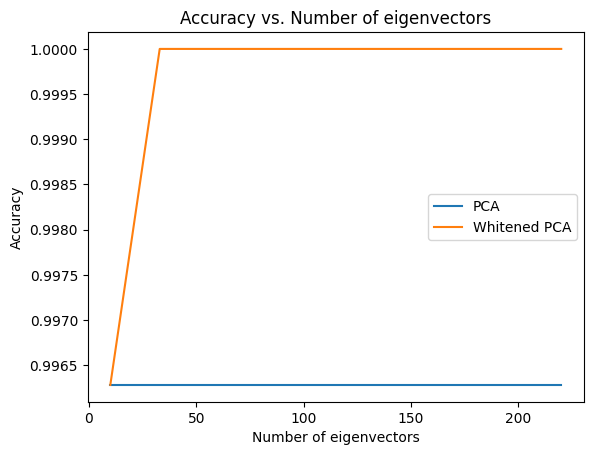

In [39]:
#Insert code Here
L = np.linspace(10, 220, 10, dtype=int)  # number of eigenvectors to keep
accuracy_PCA = np.zeros(len(L))  # store the accuracy for each L
accuracy_PCA_whitened = np.zeros(len(L))  # store the accuracy for each L

mean = np.mean(X_train, axis=0)    # returns the mean vector of the data (mean for each band)
standard_deviation = np.std(X_train, axis=0)  # returns the standard deviation of the data (std for each band)
X_train_centered = (X_train - mean)  # for each pixel, subtract the mean of the data for that band
X_test_centered = (X_test - mean)  # for each pixel, subtract the mean of the data for that band

cov_matrix = np.cov(X_train_centered.T) # covariance matrix evaluated on the centered dataset
v, w = LA.eig(cov_matrix) # extract the eigenvalues (v) and eigenvectors (w) from the covariance matrix
idx = np.argsort(v)[::-1]   # sort eigenvalues in descending order and remember the indexes
v = v[idx]  # sort eigenvalues
w = w[:, idx]   # sort eigenvectors

for i, l in enumerate(L):   # perform PCA with different number of eigenvectors extracted
    W = w[:, :l]  # select the first l 
    lambda_ = np.diag(v[:l])  # select the first l eigenvalues and build a diagonal matrix

    # apply PCA
    X_train_pca = np.dot(X_train_centered, W)  # X_pca = centered * W
    X_test_pca = np.dot(X_test_centered, W)  # X_pca = centered * W

    # apply whitening
    # whitening_matrix = np.dot(np.linalg.inv(np.sqrt(lambda_)) , W.T)  # calculate the whitened matrix
    X_train_pca_whitened = np.dot(X_train_pca, np.linalg.inv(np.sqrt(lambda_)))  # apply the whitening to the training data
    X_test_pca_whitened = np.dot(X_test_pca, np.linalg.inv(np.sqrt(lambda_)))  # apply the whitening to the testing data

    # apply LDA on basic PCA
    mu_0 = np.mean(X_train_pca[y_train == 0], axis=0)  # mean of the training data for class 0
    mu_1 = np.mean(X_train_pca[y_train == 1], axis=0)  # mean of the training data for class 1

    x_0 = 0.5 * (mu_0 + mu_1)
    weights= mu_1 - mu_0

    # LDA prediction on basic PCA
    y_pred = np.sign(np.dot((X_test_pca - x_0), weights))  # predict the class of the testing data
    y_pred = ((y_pred + 1) / 2).astype(int)  # convert the prediction to 0 and 1

    # LDA accuracy on basic PCA
    accuracy_PCA[i] = np.mean(y_pred == y_test)  # calculate the accuracy
    
    # apply LDA on whitened PCA
    mu_0 = np.mean(X_train_pca_whitened[y_train == 0], axis=0)  # mean of the training data for class 0
    mu_1 = np.mean(X_train_pca_whitened[y_train == 1], axis=0)  # mean of the training data for class 1

    x_0 = 0.5 * (mu_0 + mu_1)
    weights= mu_1 - mu_0

    # LDA prediction on whitened PCA
    y_pred = np.sign(np.dot((X_test_pca_whitened - x_0), weights))  # predict the class of the testing data
    y_pred = ((y_pred + 1) / 2).astype(int)  # convert the prediction to 0 and 1

    # LDA accuracy on whitened PCA
    accuracy_PCA_whitened[i] = np.mean(y_pred == y_test)  # calculate the accuracy

plt.plot(L, accuracy_PCA, label='PCA')
plt.plot(L, accuracy_PCA_whitened, label='Whitened PCA')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of eigenvectors')
plt.legend()
plt.show()


**Apply the classifier to the original data where only a subset of K features (selected randomly) have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)** 

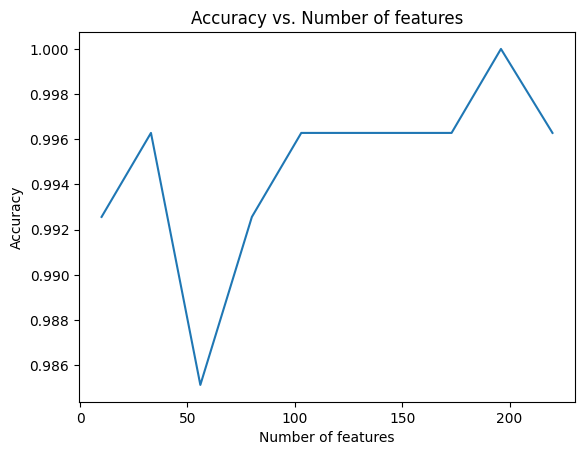

In [28]:
#Insert code here
import random
# reduce randomly the dataset to K features
L = np.linspace(10, 220, 10, dtype=int)  # number of eigenvectors to keep
accuracy = np.zeros(len(L))  # store the accuracy for each L
for i,l in enumerate(L):
    random_features = random.sample(range(combined.shape[1]), l)  # select K random features

    X_train1_ran, X_test1_ran = train_test_split(class1[:, random_features], test_size=0.25, random_state=42)
    X_train2_ran, X_test2_ran = train_test_split(class2[:, random_features], test_size=0.25, random_state=42)

    X_train_ran = np.vstack((X_train1_ran, X_train2_ran))
    X_test_ran = np.vstack((X_test1_ran, X_test2_ran))

    mu_0 = np.mean(X_train_ran[y_train == 0], axis=0)  # mean of the training data for class 0
    mu_1 = np.mean(X_train_ran[y_train == 1], axis=0)  # mean of the training data for class 1

    x_0 = 0.5 * (mu_0 + mu_1)
    weights= mu_1 - mu_0

    y_pred = np.sign(np.dot((X_test_ran - x_0), weights))  # predict the class of the testing data
    y_pred = ((y_pred + 1) / 2).astype(int)  # convert the prediction to 0 and 1

    accuracy[i] = np.mean(y_pred == y_test)  # calculate the accuracy

plt.plot(L, accuracy)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of features')
plt.show()

**Try to classify the data using a Support Vector Machine and compare the results**

In [31]:
#For this section you can use the sklearn library 
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy with SVM: {accuracy}')

Accuracy with SVM: 1.0


**Student's comments to Exercise 2**

When we perfrom PCA we are reducing the dimensionality of the dataset, but we know that when our dataset has more samples (N) than dimensions (D), then the points (samples) are not lineary separable.
If N < D : the points are not linearly separable
If N >= D : the points are linearly separable

Our goal is to reduce the dataset in the best way possible, but the starting dataset could have not enough dimensions to obrain the best solution. We can map our original dataset of D dimensions and obtain a new dataset of M dimensions, with M >> D (M is very higher then D). This process doesn't mean that we are adding features at each samples in the dataset, but it means that we evaluate a new dataset with more features evaluated by the those that we have in the starting dataset. The function that does this mapping process is $\phi(x)$ and we don't know it. Another problem is that then we would obtain a covariance matric of dimension MxM, too big and too complex to be uesed. Kernel tricks helps us to perform this mapping without knowing the $\phi$ function. Kernel tricks is based on the Kernel function $K_{i,j} = \phi(x_i) \phi(x_j)^T$, this will create a matrix K of shape NxN, and we can use it instead of the covariance matrix. This reduce a lot the complexity and made us able to map the original dataset without using the $\phi$ function.

In the exercise we see that the accuracy of the linear discriminator is high, i think that this is cause our dataset has an high number of dimensions and the points of the two classes are clearly separable, so they are linearly separable. We are also performing LDA on the dataset after having applied PCA with the withening. This is the process where we measure the proportionality of the covariance matrix with the identity matrix: $x_i = \Lambda^{-\frac{1}{2}}W^T x_i$